# 2: Small Worlds and Large Worlds

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

import torch
import torch.tensor as tt
import pyro
from pyro.distributions import (
    Bernoulli,
    Beta,
    Binomial,
    Categorical,
    Normal,
    Uniform,
)

### Code 2.1

Normalize a list of counts to produce a probability distribution

In [2]:
ways = np.array([0, 3, 8, 9, 0])
print(ways/sum(ways))

[0.   0.15 0.4  0.45 0.  ]


### Code 2.2

Compute the likelihood of getting six successes in nine trials with a success probability of 50% using a binomial distribution.

In [3]:
# Using scipy's stats module
st.binom(n=9, p=0.5).pmf(6)

0.16406250000000006

In [4]:
# Using pyro's distributions
Binomial(total_count=9, probs=0.5).log_prob(tt(6.)).exp().item()

0.1640624701976776

### Code 2.3

Using the "grid approximation" to condition models

In [5]:
def calc_posterior(n_points=20):
    # Define the grid
    p_grid = np.linspace(0, 1, n_points)
    # Define uniform prior (un-normalized)
    prior = np.ones(n_points)
    # Compute likelihood at each point
    likelihood = st.binom(n=9, p=p_grid).pmf(6)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

### Code 2.4
Display the results of the above computation

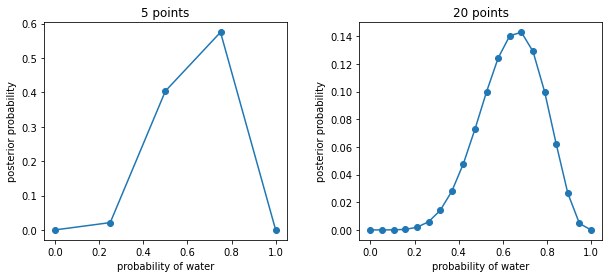

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for n, ax in zip((5, 20), axes):
    p_grid, posterior = calc_posterior(n)
    ax.plot(p_grid, posterior, marker="o")
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{n} points")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 2.5
Do the same thing as above, but for some different priors

In [7]:
def calc_posterior(prior):
    # Define the grid
    n_points = len(prior)
    p_grid = np.linspace(0, 1, n_points)
    # Compute likelihood at each point
    likelihood = st.binom(n=9, p=p_grid).pmf(6)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

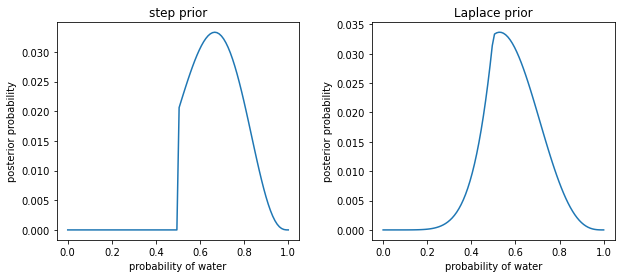

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
n_points = 100
p_grid = np.linspace(0, 1, n_points)
priors = np.array([
    [0 if p < 0.5 else 1 for p in p_grid], # step function
    np.exp(-5*np.abs(p_grid - 0.5)), # Laplace prior
])
for prior, ax, label in zip(priors, axes, ("step", "Laplace")):
    p_grid, posterior = calc_posterior(prior)
    ax.plot(p_grid, posterior)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{label} prior")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 2.6

Compute the quadratic approximation (the posterior is approximated as a Gaussian centered on the MAP estimate) for the globe model:
$$
p \sim \text{Uniform}(0, 1) \\
W \sim \text{Binomial}(W+L, p) \\
\text{data: } W=6, L=3
$$
McElreath uses some black box function `quap` to perform the calculation. Since no equivalent function to `quap` exists in `pyro` (that I know of), we're just gonna have to roll our own. First we compute the MAP estimate for $p$ using vanilla gradient descent.

In [9]:
# First, we compute the MAP estimate
pyro.clear_param_store()
# Specify the model
def model(W, L):
    N = tt(W+L)
    # p is an optimizable parameter instead of a sampled value
    p = pyro.param("p", Uniform(0., 1.).sample())
    # Condition on the observed value of W
    pyro.sample("W", Binomial(N, p), obs=tt(W))

# Trace the model so that we can inspect it when it runs
traced_model = pyro.poutine.trace(model)
vals = []
# Use vanilla gradient descent to maximize the likelihood
for _ in range(1000):
    tr = traced_model.get_trace(6., 3.)
    p = tr.nodes["p"]["value"]
    log_L = tr.log_prob_sum() # log likelihood
    log_L.backward() # Differentiate likelihood wrt parameters (p)
    p.data += 1e-3*p.grad # gradient update
    p.grad.zero_()
    vals.append(p.item())
print(f"MAP estimate: p={vals[-1]:.4f}")

MAP estimate: p=0.6667


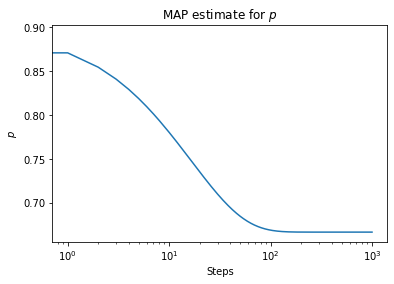

In [10]:
plt.plot(vals)
plt.xscale('log')
plt.title("MAP estimate for $p$")
plt.xlabel("Steps")
plt.ylabel("$p$")
plt.show()

Then we compute the "curvature" at the peak in order to estimate the standard deviation. The reason why becomes apparent if you look at the log of the normal distribution:
$$
N(x;\mu,\sigma) \propto \exp\left(-(x-\mu)^2/2\sigma^2\right) \\
\log N(x; \mu,\sigma) = f(x) = -(x-\mu)^2/2\sigma^2 + C
$$
we can see that if we expand $f(x)$ around $x=\mu$ to second order, we recover the equation itself, because $f(x)$ is a parabola with
$$
f(\mu) = C,\quad f^\prime(\mu) = 0,\quad f^{\prime\prime}(\mu) = -1/2\sigma^2
$$
so that the relationship between the second derivative and $\sigma$ is
$$
\sigma = 1/\sqrt{-f^{\prime\prime}(\mu)}
$$

In [11]:
# Compute the "curvature" (second derivative) of the log
# likelihood wrt p
tr = traced_model.get_trace(6., 3.)
p = tr.nodes["p"]["value"]
log_L = tr.log_prob_sum()
# Compute the second derivative of the log likelihood wrt p
g = torch.autograd.grad(log_L, p, create_graph=True)[0]
g2 = torch.autograd.grad(g, p)[0]
print(f"2nd derivative is {g2.item():.3f}")
stddev = 1/torch.sqrt(-g2)
print(f"Which means that the stddev is {stddev.item():.3f}")

2nd derivative is -40.500
Which means that the stddev is 0.157


### Code 2.7
Do the same thing, but analytically, using a beta distribution for $p$ (beta is the conjugate prior to the binomial distribution, and generalizes the uniform distribution)

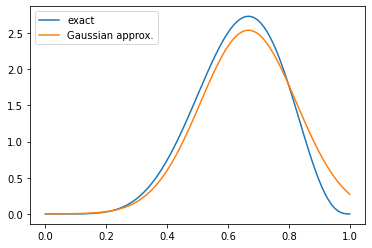

In [12]:
x = torch.linspace(0.001, 0.999, 100)
y1 = Beta(6.+1, 3.+1).log_prob(x).exp()
y2 = Normal(p, stddev).log_prob(x).exp().detach()
plt.plot(x, y1, label="exact")
plt.plot(x, y2, label="Gaussian approx.")
plt.legend()
plt.show()

### Code 2.8
Use vanilla MCMC to infer the posterior distribution of $p$ for the globe model

In [13]:
n_samples = 10000
p = list()
p.append(tt(0.5))
W = tt(6.)
L = tt(3.)
for i in range(1, n_samples):
    # Take a small step away from the previous sample
    p_new = Normal(p[i-1], 0.1).sample()
    # If the step is outside [0, 1], squish it back in there
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    # Get the likelihood of the previous/current step
    q0 = Binomial(W+L, p[i-1]).log_prob(W).exp()
    q1 = Binomial(W+L, p_new).log_prob(W).exp()
    # Reject the new sample if the likelihood ratio isn't high enough
    if Uniform(0, 1).sample() < q1/q0:
        p.append(p_new)
    else:
        p.append(p[i-1])

### Code 2.9
Plot the results of the MCMC simulation and compare with the analytical posterior

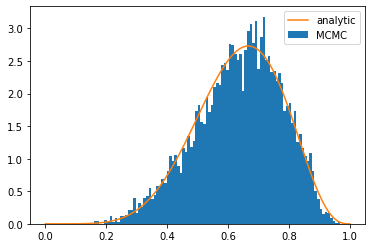

In [14]:
plt.hist(p, bins=100, label="MCMC", density=True)
x = torch.linspace(0, 1, 100)
y = Beta(W+1, L+1).log_prob(x).exp()
plt.plot(x, y, label="analytic")
plt.legend()
plt.show()

## Practice problems

### 2E1
Which of the expressions below correspond to the statement "the probability of rain on Monday"?
1. Pr(rain)
2. Pr(rain|Monday)
3. Pr(Monday|rain)
4. Pr(rain,Monday)/Pr(Monday)

Answer: the probability of rain on Monday can be rephrased as the probability of rain, given that it is Monday, so the answer is (2). However, because of Bayes rule, (4) is also mathematically equivalent to (2), so they are both right.

### 2E2
Which of the following statements corresponds to the expression: Pr(Monday|rain)?
1. The probability of rain on Monday
2. The probability of rain, given that it is Monday
3. The probability that it is Monday, given that it is raining
4. The probability that it is Monday and that it is raining

Answer: That expression literally translates into (3). It is not (4) because that's the _joint_ probability Pr(Monday, rain)

### 2E3
Which of the expressions below correspond to the statement "the probability that it is Monday, given that it is raining"?

1. Pr(Monday|rain)
2. Pr(rain|Monday)
3. Pr(rain|Monday) Pr(Monday)
4. Pr(rain|Monday) Pr(Monday) / Pr(rain)
5. Pr(Monday|rain) P(rain) / Pr(Monday)

Answer: So first off, (3) is equivalent to the joint distribution Pr(rain, Monday), and (4)\~(1) and (5)\~(2) by Bayes' rule. The statement of interest is equivalent to Pr(Monday|rain), which is then equal to choices (1) and (4)

### 2E4
The "probability of water is 0.7" in the context of the globe tossing model means that the probability of your thumb landing on water after a toss is 0.7. Assuming that your thumb is equally likely to land anywhere on the surface, this means that the fraction of the surface of the globe that is covered in water is then 0.7.

### 2M1
Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for $p$:
1. W, W, W (W=3, L=0)
2. W, W, W, L (W=3, L=1)
3. L, W, W, L, W, W, W (W=5, L=2)

In [15]:
def calc_posterior(W, L):
    p_grid = np.linspace(0, 1, 100)
    prior = np.ones(p_grid.shape)
    L = st.binom(n=W+L, p=p_grid).pmf(W)
    posterior = L * prior
    posterior /= sum(posterior)
    return p_grid, posterior

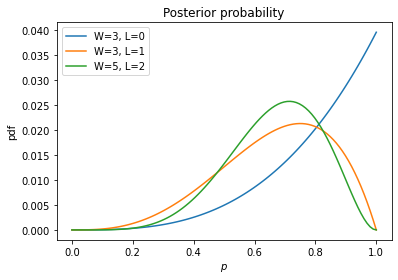

In [16]:
for W, L in ((3, 0), (3, 1), (5, 2)):
    x, y = calc_posterior(W, L)
    plt.plot(x, y, label=f"W={W}, L={L}")
plt.xlabel("$p$")
plt.ylabel("pdf")
plt.title("Posterior probability")
plt.legend()
plt.show()

### 2M2
Same as 2M1, but assume a step prior that is zero for $p < 0.5$ and constant otherwise.

In [17]:
def calc_posterior(W, L):
    p_grid = np.linspace(0, 1, 100)
    prior = np.ones(p_grid.shape)
    prior[p_grid<0.5] = 0
    L = st.binom(n=W+L, p=p_grid).pmf(W)
    posterior = L * prior
    posterior /= sum(posterior)
    return p_grid, posterior

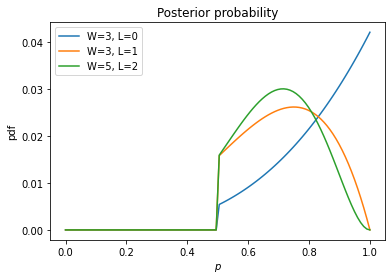

In [18]:
for W, L in ((3, 0), (3, 1), (5, 2)):
    x, y = calc_posterior(W, L)
    plt.plot(x, y, label=f"W={W}, L={L}")
plt.xlabel("$p$")
plt.ylabel("pdf")
plt.title("Posterior probability")
plt.legend()
plt.show()

### 2M3
Suppose you have two globes, one for Earth and one for Mars. Earth has fraction 0.7 water, but Mars is 100% land. Show that the posterior probability that the globe is Earth, conditional on seeing land, is 0.23.

Ok, I'm going to do this a couple ways. First, the easy numerical simulation method. We compute Pr(Earth|land) by simulating a bunch tosses, tossing out any that don't result in land, and see what fraction of them are Earth

In [19]:
def simulation(n_samples):
    # sample a planet with equal probability
    planets = np.random.choice(["earth", "mars"], n_samples)
    # toss it and see where it lands
    p = np.random.rand(n_samples)
    terrain = np.empty(n_samples, dtype=str)
    for planet, w_prob in zip(("earth", "mars"), (0.7, 0)):
        mask = (planets == planet)
        terrain[mask & (p < w_prob)] = "W"
        terrain[mask & (p >= w_prob)] = "L"
    return planets, terrain

def calc_conditional_prob():
    planets, terrain = simulation(int(1e6))
    mask = (terrain == "L")
    planets = planets[mask]
    return sum(planets == "earth")/len(planets)

In [20]:
calc_conditional_prob()

0.23031890001354663

Then, we'll do it analytically. We assume that the Earth/Mars choice is a Bernoulli RV with $p=0.5$, so that Pr(Earth)=Pr(Mars)=1/2. The conditional probabilities Pr(land|Earth) = 0.3 and Pr(land|Mars) = 1, so from Bayes' rule we have:
$$
\begin{align}
Pr(\text{Earth}|\text{land}) & = Pr(\text{Earth}, \text{land})/Pr(\text{land}) \\
& = Pr(\text{land} | \text{Earth}) Pr(\text{Earth})/ Pr(\text{land}) \\
& = 0.3 * 0.5/ Pr(\text{land}) \\
& = 0.15/ \left[Pr(\text{land}|\text{Earth}) Pr(\text{Earth}) + Pr(\text{land}|\text{Mars}) Pr(\text{Mars})\right] \\
&= 0.15/\left[ 0.3*0.5 + 1*0.5 \right] \\
&\approx 0.2307
\end{align}
$$

In [21]:
0.15/(0.3*0.5 + 1*0.5)

0.23076923076923075

Next we'll use `pyro` to figure it out by sampling the model, then analyzing the samples

In [22]:
# Specify model
def model():
    planet = pyro.sample("planet", Bernoulli(tt(0.5))) # 0=earth, 1=mars
    if planet == 0:
        terrain = pyro.sample("terrain", Bernoulli(tt(0.3))) # 0=water, 1=land
    else:
        terrain = pyro.sample("terrain", Bernoulli(tt(1.))) # 0=water, 1=land

In [23]:
# Get model traces
planets = list()
terrains = list()
traced_model = pyro.poutine.trace(model)
for _ in range(10000):
    tr = traced_model.get_trace()
    planets.append(tr.nodes["planet"]["value"])
    terrains.append(tr.nodes["terrain"]["value"])
planets = np.array(planets)
terrains = np.array(terrains)

In [24]:
# Calculate probability
mask = (terrains == 1)
planets = planets[mask]
sum(planets == 0)/len(planets)

0.23238357843137256